In [323]:
from collections import defaultdict

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx
import pgmpy as pgmpy
import seaborn as sns
from itertools import combinations, product
from ipywidgets import interact, fixed, widgets
from pgmpy.models import NaiveBayes, BayesianModel, BayesianNetwork, MarkovModel, FactorGraph, JunctionTree
from pgmpy.inference import VariableElimination
from pgmpy.estimators import TreeSearch, ParameterEstimator, BayesianEstimator, MaximumLikelihoodEstimator, BayesianEstimator
from tabulate import tabulate as tab


In [324]:
df = pd.read_csv('Dataset/heart_failure_clinical_records_dataset.csv')
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


In [325]:
df.shape
print("There are {} rows and {} columns".format(df.shape[0], df.shape[1]))

There are 299 rows and 13 columns


In [326]:
df.describe()


,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
count,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.000000,299.00000,299.000000,299.000000,299.00000,299.000000,299.00000
mean,60.833893,0.431438,581.839465,0.418060,38.083612,0.351171,263358.029264,1.39388,136.625418,0.648829,0.32107,130.260870,0.32107
std,11.894809,0.496107,970.287881,0.494067,11.834841,0.478136,97804.236869,1.03451,4.412477,0.478136,0.46767,77.614208,0.46767
min,40.000000,0.000000,23.000000,0.000000,14.000000,0.000000,25100.000000,0.50000,113.000000,0.000000,0.00000,4.000000,0.00000
25%,51.000000,0.000000,116.500000,0.000000,30.000000,0.000000,212500.000000,0.90000,134.000000,0.000000,0.00000,73.000000,0.00000
50%,60.000000,0.000000,250.000000,0.000000,38.000000,0.000000,262000.000000,1.10000,137.000000,1.000000,0.00000,115.000000,0.00000
75%,70.000000,1.000000,582.000000,1.000000,45.000000,1.000000,303500.000000,1.40000,140.000000,1.000000,1.00000,203.000000,1.00000
max,95.000000,1.000000,7861.000000,1.000000,80.000000,1.000000,850000.000000,9.40000,148.000000,1.000000,1.00000,285.000000,1.00000


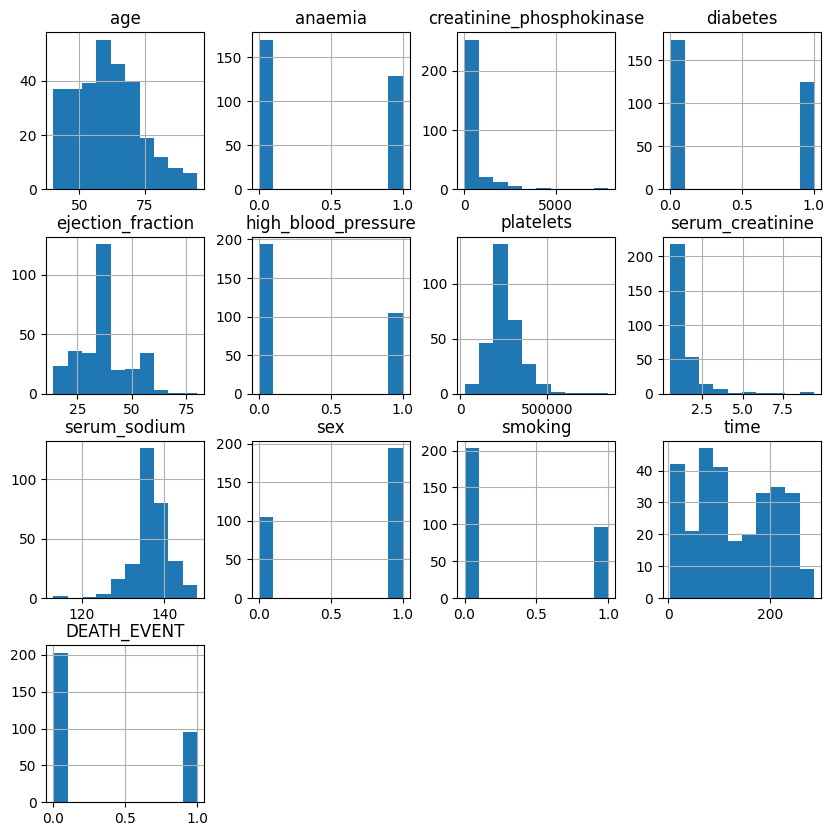

In [327]:
pd.DataFrame.hist(df,figsize = [10,10]);

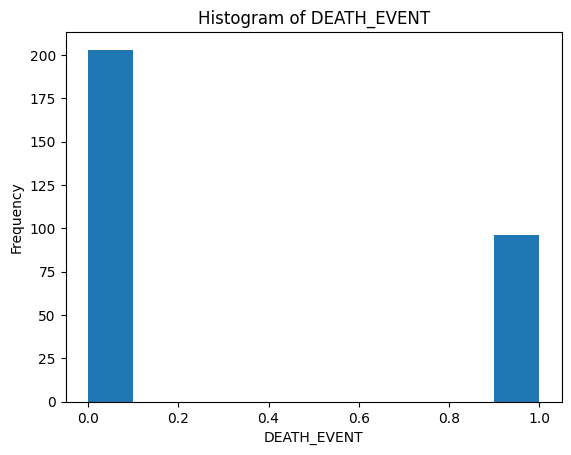

In [328]:
# Define the target variable
target = 'DEATH_EVENT'

# Plot histogram
plt.hist(df[target])
plt.title('Histogram of {}'.format(target))
plt.xlabel(target)
plt.ylabel('Frequency')

# Show the plot
plt.show()

In [329]:
df.columns

Index(['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes',
       'ejection_fraction', 'high_blood_pressure', 'platelets',
       'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'time',
       'DEATH_EVENT'],
      dtype='object')

In [330]:
np.sum(pd.isnull(df), 0)



age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

In [331]:
data = {}
dic = { 
    'age':[0,50,60,75,95], 
    'creatinine_phosphokinase':[20,200,350,550,3000,8000], 
    'ejection_fraction': [0, 40, 50, 70, 100], 
    'platelets':[0, 160000, 370000, 850000],
    'serum_creatinine': [0, 0.48, 1.0, 1.5, 3.5, 9.5],
    'serum_sodium': [110, 135, 145, 150],
    'time': [0, 70, 160, 300]
    }
for key, val in dic.items():
    bin = pd.cut(df[key], val)
    interval = {x: i for i, x in enumerate(bin.dtype.categories)}
    data[key] = interval
    df[key] = bin.apply(lambda x: interval[x])


for col, map in data.items():
    print(col)
    table = tab(map.items(), headers=['Interval', 'Value'], tablefmt='fancy_grid')
    print(table, end='\n\n')


    

age
╒════════════╤═════════╕
│ Interval   │   Value │
╞════════════╪═════════╡
│ (0, 50]    │       0 │
├────────────┼─────────┤
│ (50, 60]   │       1 │
├────────────┼─────────┤
│ (60, 75]   │       2 │
├────────────┼─────────┤
│ (75, 95]   │       3 │
╘════════════╧═════════╛

creatinine_phosphokinase
╒══════════════╤═════════╕
│ Interval     │   Value │
╞══════════════╪═════════╡
│ (20, 200]    │       0 │
├──────────────┼─────────┤
│ (200, 350]   │       1 │
├──────────────┼─────────┤
│ (350, 550]   │       2 │
├──────────────┼─────────┤
│ (550, 3000]  │       3 │
├──────────────┼─────────┤
│ (3000, 8000] │       4 │
╘══════════════╧═════════╛

ejection_fraction
╒════════════╤═════════╕
│ Interval   │   Value │
╞════════════╪═════════╡
│ (0, 40]    │       0 │
├────────────┼─────────┤
│ (40, 50]   │       1 │
├────────────┼─────────┤
│ (50, 70]   │       2 │
├────────────┼─────────┤
│ (70, 100]  │       3 │
╘════════════╧═════════╛

platelets
╒══════════════════╤═════════╕
│ Interv

In [332]:
df
legenda = {'age':{0: '0-50', 1: '50-60', 2: '60-75', 3: '75-95'},
            'creatine_phosphokinase':{0: '0-20', 1: '20-200', 2: '200-350', 3: '350-550', 4: '550-3000', 5: '3000-8000'},
            'ejection_fraction':{0: '0-40', 1: '40-50', 2: '50-70', 3: '70-100'},
            'platelets':{0: '0-160000', 1: '160000-370000', 2: '370000-850000'},
            'serum_creatinine':{0: '0-0.48', 1: '0.48-1.0', 2: '1.0-1.5', 3: '1.5-3.5', 4: '3.5-9.5'},
            'serum_sodium':{0: '110-135', 1: '135-145', 2: '145-150'},
            'time':{0: '0-70', 1: '70-160', 2: '160-300'},
            'DEATH_EVENT':{0: 'Alive', 1: 'Dead'},
            'anaemia':{0: 'No', 1: 'Yes'},
            'diabetes':{0: 'No', 1: 'Yes'},
            'high_blood_pressure':{0: 'No', 1: 'Yes'},
            'sex':{0:'Female', 1:'Male'},
            'smoking':{0: 'Yes', 1: 'No'}
            }



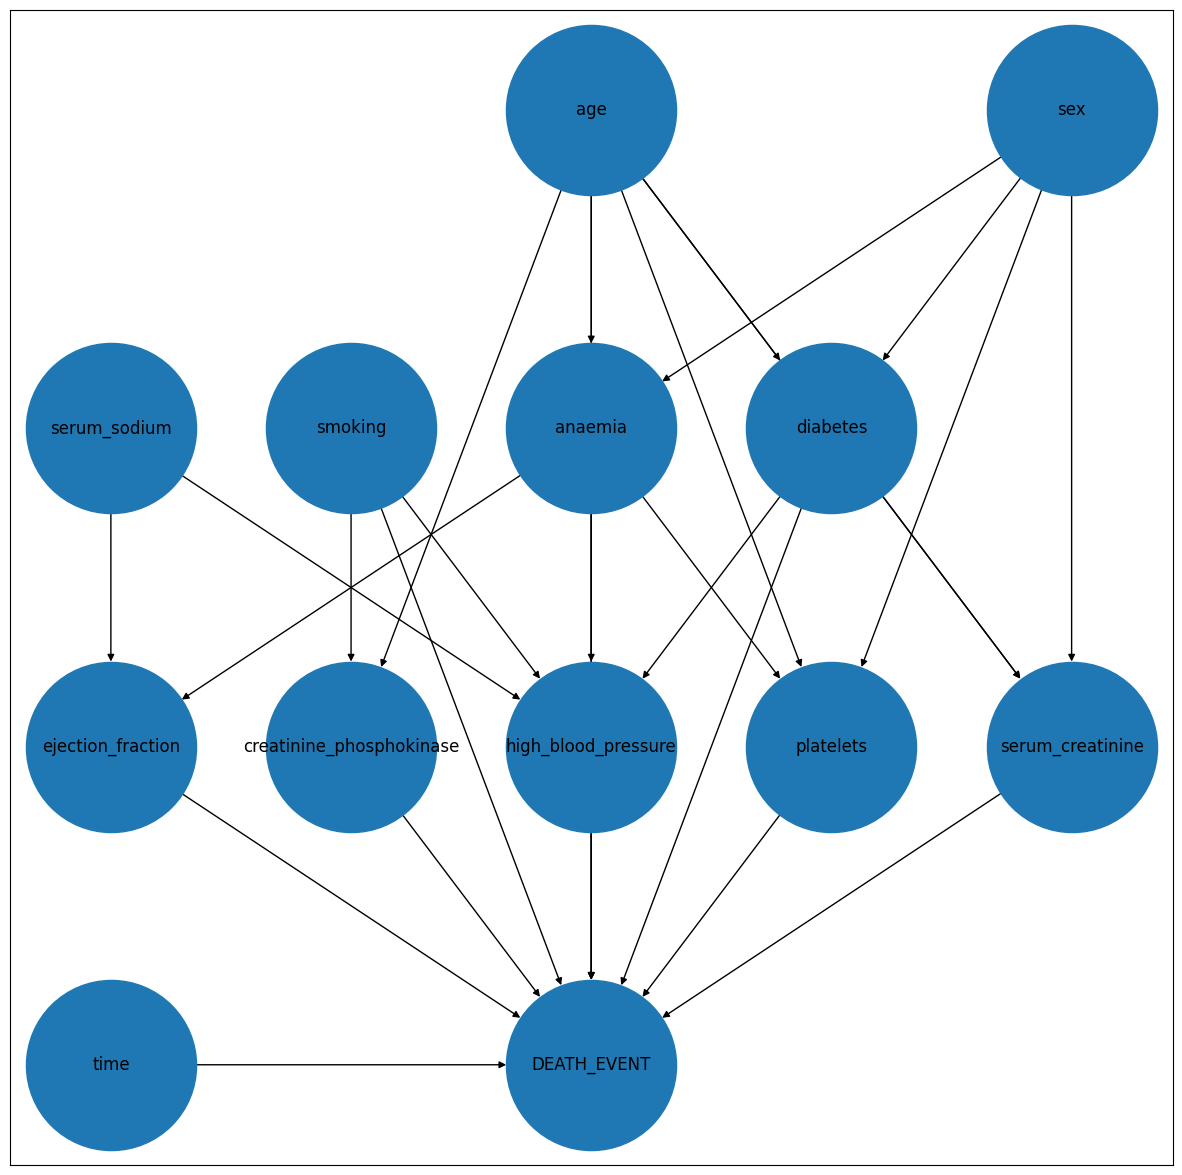

In [333]:
network = BayesianNetwork([
                    ('age','anaemia'), 
                    ('age', 'creatinine_phosphokinase'),
                    ('age', 'diabetes'),
                    ('age', 'platelets'),
                    ('age', 'serum_creatinine'),
                    ('age', 'DEATH_EVENT'),
                    ('sex','anaemia'),
                    ('sex', 'diabetes'),
                    ('sex', 'platelets'),
                    ('sex', 'serum_creatinine'),
                    ('anaemia', 'ejection_fraction'),
                    ('anaemia', 'high_blood_pressure'),
                    ('anaemia', 'platelets'),
                    ('anaemia', 'DEATH_EVENT'),
                    ('diabetes', 'high_blood_pressure'),
                    ('diabetes', 'serum_creatinine'),
                    ('diabetes', 'DEATH_EVENT'),
                    ('smoking', 'high_blood_pressure'),
                    ('smoking', 'creatinine_phosphokinase'),
                    ('smoking', 'DEATH_EVENT'),
                    ('serum_sodium', 'high_blood_pressure'),
                    ('serum_sodium', 'ejection_fraction'),
                    ('ejection_fraction', 'DEATH_EVENT'),
                    ('high_blood_pressure', 'DEATH_EVENT'),
                    ('serum_creatinine', 'DEATH_EVENT'),
                    ('creatinine_phosphokinase', 'DEATH_EVENT'),
                    ('platelets', 'DEATH_EVENT'), 
                    ('time', 'DEATH_EVENT')
                    ])
pos={
    'age':[0.75, -0.5], 'sex':[1.25, -0.5],
    'serum_sodium':[0.25, -1], 'smoking':[0.50, -1], 'anaemia':[0.75, -1], 'diabetes':[1, -1],
    'ejection_fraction':[0.25, -1.5], 'creatinine_phosphokinase':[0.50, -1.5], 'high_blood_pressure':[0.75, -1.5], 'platelets':[1, -1.5], 'serum_creatinine':[1.25, -1.5],
    'time':[0.25,-2], 'DEATH_EVENT':[0.75, -2]
    }

fig,ax = plt.subplots(1, 1, figsize=(15,15))
nx.draw_networkx(network, pos=pos, ax=ax, node_size=15000)


In [334]:
np.sum(pd.isnull(df), 0)


age                         0
anaemia                     0
creatinine_phosphokinase    0
diabetes                    0
ejection_fraction           0
high_blood_pressure         0
platelets                   0
serum_creatinine            0
serum_sodium                0
sex                         0
smoking                     0
time                        0
DEATH_EVENT                 0
dtype: int64

Building tree: 100%|██████████| 78/78.0 [00:00<00:00, 840.27it/s]


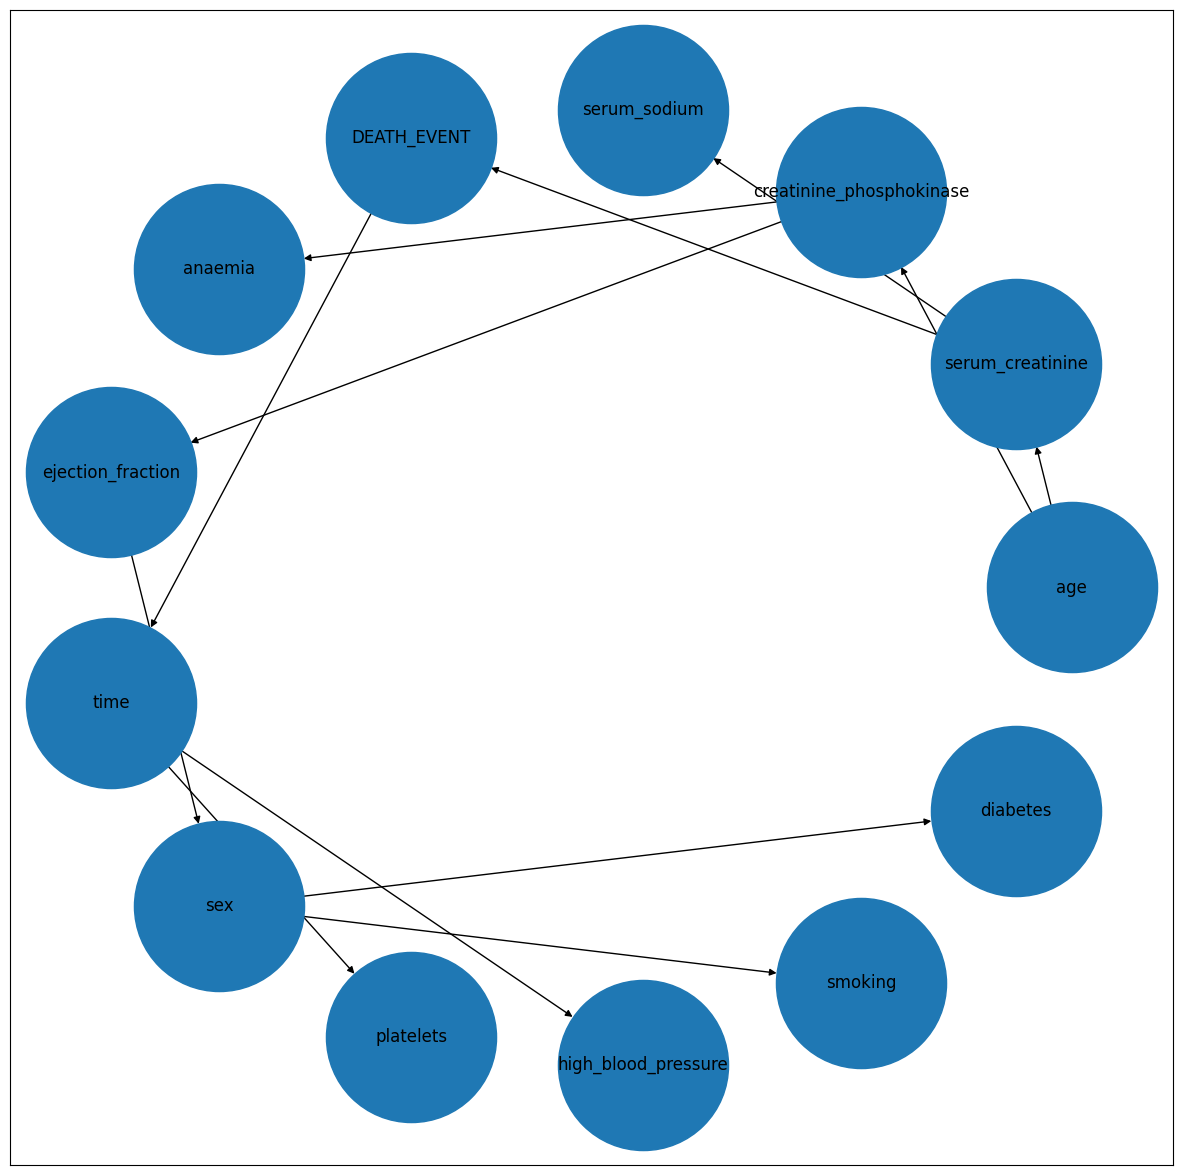

In [335]:
ts = TreeSearch(data=df, root_node='age')
tree_model = ts.estimate(show_progress=True) 

fig,ax = plt.subplots(1, 1, figsize=(15,15))
nx.draw_networkx(tree_model, pos=nx.drawing.layout.circular_layout(tree_model), ax=ax, node_size=15000)

In [336]:
mle = MaximumLikelihoodEstimator(network, data=df)
be = BayesianEstimator(network, data=df)
for x in df.columns:
    print(x)
    print("Maximum Likelihood Estimator\n", mle.estimate_cpd(x))
    print("Bayesian Estimator\n", be.estimate_cpd(x))



age
Maximum Likelihood Estimator
 +--------+----------+
| age(0) | 0.247492 |
+--------+----------+
| age(1) | 0.294314 |
+--------+----------+
| age(2) | 0.35786  |
+--------+----------+
| age(3) | 0.100334 |
+--------+----------+
Bayesian Estimator
 +--------+----------+
| age(0) | 0.247533 |
+--------+----------+
| age(1) | 0.293586 |
+--------+----------+
| age(2) | 0.356086 |
+--------+----------+
| age(3) | 0.102796 |
+--------+----------+
anaemia
Maximum Likelihood Estimator
 +------------+---------------------+-----+--------------------+--------+
| age        | age(0)              | ... | age(3)             | age(3) |
+------------+---------------------+-----+--------------------+--------+
| sex        | sex(0)              | ... | sex(0)             | sex(1) |
+------------+---------------------+-----+--------------------+--------+
| anaemia(0) | 0.5483870967741935  | ... | 0.3333333333333333 | 0.5    |
+------------+---------------------+-----+--------------------+--------+
|

c:\Shell\Python\Lib\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
c:\Shell\Python\Lib\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)
c:\Shell\Python\Lib\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and 

Bayesian Estimator
 +---------+----------+
| time(0) | 0.239035 |
+---------+----------+
| time(1) | 0.373904 |
+---------+----------+
| time(2) | 0.387061 |
+---------+----------+
DEATH_EVENT


c:\Shell\Python\Lib\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


Maximum Likelihood Estimator
 +--------------------------+-----+-----------------------------+
| age                      | ... | age(3)                      |
+--------------------------+-----+-----------------------------+
| anaemia                  | ... | anaemia(1)                  |
+--------------------------+-----+-----------------------------+
| creatinine_phosphokinase | ... | creatinine_phosphokinase(4) |
+--------------------------+-----+-----------------------------+
| diabetes                 | ... | diabetes(1)                 |
+--------------------------+-----+-----------------------------+
| ejection_fraction        | ... | ejection_fraction(3)        |
+--------------------------+-----+-----------------------------+
| high_blood_pressure      | ... | high_blood_pressure(1)      |
+--------------------------+-----+-----------------------------+
| platelets                | ... | platelets(2)                |
+--------------------------+-----+--------------------------

c:\Shell\Python\Lib\site-packages\pgmpy\estimators\base.py:170: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  data.groupby([variable] + parents).size().unstack(parents)


+--------------------------+-----+-----------------------------+
| age                      | ... | age(3)                      |
+--------------------------+-----+-----------------------------+
| anaemia                  | ... | anaemia(1)                  |
+--------------------------+-----+-----------------------------+
| creatinine_phosphokinase | ... | creatinine_phosphokinase(4) |
+--------------------------+-----+-----------------------------+
| diabetes                 | ... | diabetes(1)                 |
+--------------------------+-----+-----------------------------+
| ejection_fraction        | ... | ejection_fraction(3)        |
+--------------------------+-----+-----------------------------+
| high_blood_pressure      | ... | high_blood_pressure(1)      |
+--------------------------+-----+-----------------------------+
| platelets                | ... | platelets(2)                |
+--------------------------+-----+-----------------------------+
| serum_creatinine       

SIMPLIFY CPD? NOISY OR 

In [337]:
network.fit(data=df, estimator=MaximumLikelihoodEstimator) 



In [338]:
print("Total number of valid indipendencies: ", len(network.get_independencies().get_assertions()))
for node in network.nodes():
    print("Local independencies: ", network.local_independencies(node))

Total number of valid indipendencies:  20080
Local independencies:  (age ⟂ smoking, time, serum_sodium, sex)
Local independencies:  (anaemia ⟂ smoking, diabetes, time, serum_creatinine, serum_sodium, creatinine_phosphokinase | age, sex)
Local independencies:  (creatinine_phosphokinase ⟂ ejection_fraction, serum_creatinine, serum_sodium, sex, anaemia, diabetes, time, platelets, high_blood_pressure | smoking, age)
Local independencies:  (diabetes ⟂ smoking, ejection_fraction, anaemia, time, serum_sodium, platelets, creatinine_phosphokinase | age, sex)
Local independencies:  (platelets ⟂ smoking, ejection_fraction, serum_creatinine, serum_sodium, creatinine_phosphokinase, diabetes, time, high_blood_pressure | anaemia, age, sex)
Local independencies:  (serum_creatinine ⟂ smoking, ejection_fraction, serum_sodium, creatinine_phosphokinase, anaemia, time, platelets, high_blood_pressure | diabetes, age, sex)
Local independencies:  (DEATH_EVENT ⟂ serum_sodium, sex | smoking, ejection_fraction, 

Performing inference

Question: Probability of Anaemia and Diabetes affects the probability of High Blood Pressure?

In [339]:
def plot_bar(data, title, evidences, target):
    dataFrame = pd.DataFrame([[str(x), legenda[target][bars], float(y)]
                 for x in data.keys()
                 for bars, y in enumerate(data[x])],
                 columns=[str(evidences), str(target), 'Probability'])

    fig, ax = plt.subplots(1, 1, figsize=(15, 5))
    sns.barplot(x=str(evidences), y='Probability', hue=str(target), data=dataFrame, ax=ax, palette='dark')
    plt.title(title)
    plt.show()

In [340]:
def inference(evidences, target, network, combinations=None, plot=True):
    inferences = VariableElimination(network)
    res = {}

    if combinations is None:
        max_values = [len(network.get_cpds(x).values) for x in evidences]
        combinations = list(product(*(range(max_value) for max_value in max_values)))
    
    for x in combinations:
        q = inferences.query(variables=[target], evidence={evidences[i]: x[i] for i in range(len(evidences))})
        res[(x)] = q.values


    if plot:
        plot_bar(res, 'INFERENCES', evidences, target)

    return res